In [1]:
# %autosave 0

# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?

This session covers:
- Accuracy as a way of evaluating binary classification models and its limitations.
- Determining where our model makes mistakes using a confusion table.
- Deriving other metrics like precision and recall from the confusion table.
- Using ROC (receiver operating characteristics) and AUC (area under the ROC curve) to further understand the performance of a binary classification model.
- Cross-validating a model to make sure it behaves optimally.
- Tuning the parameters of a model to achieve the best predictive performance. 

## 4.1 Evaluation metrics: session overview 
The fourth week of Machine Learning Zoomcamp is about different metrics to evaluate a binary classifier. These measures include accuracy, confusion table, precision, recall, ROC curves (TPR, FRP, random model, and ideal model),AUC (area under the ROC curve), and cross-validation. 
* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [5]:
# df = pd.read_csv('data-week-3.csv')
df = pd.read_csv(data)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

**Accuracy** measures the fraction of correct predictions. Specifically, it is the number of correct predictions divided by the total number of predictions. 

We can change the **decision threshold**, it should not be always 0.5. But, in this particular problem, the best decision cutoff, associated with the highest accuracy (80%), was indeed 0.5. 

Note that if we build a dummy model in which the decision cutoff is 1 and the algorithm predicts that no clients will churn, the accuracy would be 73%. As a result, we can see that the improvement of the original model with respect to the dummy model is not as high as we would expect.

Therefore, in this problem, accuracy cannot tell us how good is the model because the dataset is **unbalanced**, which means that there are more instances from one category than the other. This is also known as **class imbalance**.

**Classes and methods:**
- `np.linspace(x, y, z)` - returns a numpy array starting at `x` until `y` with `z` evenly spaced samples.
- `Counter(x)` - collection class that counts the number of instances that satisfy the `x` condition.
- `accuracy_score(x, y)` - `sklearn.metrics` function for calculating the accuracy of a model, given a predicted `x` dataset and a target `y` dataset. 

In [10]:
len(y_val)

1409

In [11]:
# Tells us the number of correct decisions made
(y_val == churn_decision).sum()

np.int64(1131)

In [12]:
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

\# of correct predictions / total # of predictions = 1131 / 1409 = 80%

In [13]:
1131/ 1409

0.8026969481902059

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy_score(y_val, y_pred >= 0.5)

0.8026969481902059

Here, we use 0.5 as the decision threshold. 

We want to know why we use 0.5 and if it is a good decision threshold. 

Let's try a bunch of other decision thresholds to see if it improves our accuracy. 

In [16]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [17]:
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.735
0.30 0.759
0.35 0.765
0.40 0.783
0.45 0.791
0.50 0.803
0.55 0.802
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


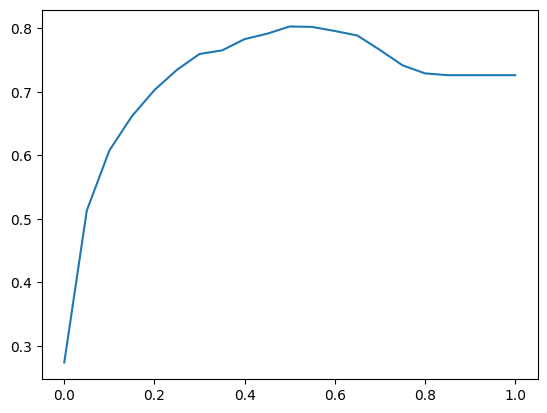

In [18]:
# Create a plot that shows how accuracy changes depending on the threshold
plt.plot(thresholds, scores)

It turns out that the 0.5 threshold is indeed the best choice for this specific problem. 

In [19]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.735
0.30 0.759
0.35 0.765
0.40 0.783
0.45 0.791
0.50 0.803
0.55 0.802
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


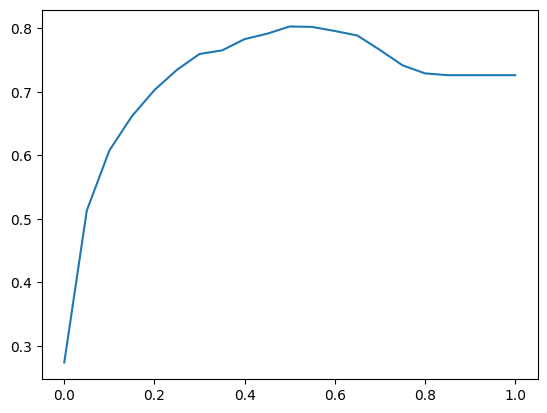

In [20]:
plt.plot(thresholds, scores)

In [21]:
from collections import Counter

In [22]:
# Count # of false values in dummy model predictions
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

To understand whether 80% is actually a good accuracy score, let's relate it to a simple baseline that's easy to understand. One such baseline could be a dummy model that always predicts the same value. 

In our churn prediction project, the dataset is imbalanced such that we don't have many churned customers. As such, the dummy model can always predict the majority class (no churn). In short, this model will always output False, regardless of the features. This kind of model is not super useful but can be used as a baseline when comparing the model with the other models. 

Our model: 80%

Dummy model: 73%

Our model is 7% more accurate than the dummy model. 


In [23]:
len(y_val)

1409

In [24]:
# Count # of false & true values in validation set
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [25]:
y_val.mean()

np.float64(0.2739531582682754)

27% of the validation dataset are made up of customers that are churning.

In [26]:
1 - y_val.mean()

np.float64(0.7260468417317246)

About 73% of the validation dataset are made up of customers not churning. 

According to accuracy, our model is only slightly better than a dummy model that treats all the customers as non-churning and doesn't attempt to keep any of them. 

We also see that there is class imbalance (more instances of one class than another) in the dataset, where about 73% of customers did not churn, and only 27% did churn. In such cases, we need a different way of measuring the quality of our models because the accuracy metric can be misleading when we have class imbalance. 

## 4.3 Confusion table
Confusion table is a way of measuring different types of errors and correct decisions that binary classifiers can make. 
* Different types of errors and correct decisions
* Arranging them in a table

Considering this information, it is possible to evaluate the quality of the model by different strategies. 

When it comes to the predictions of a Logistic Regression model, each falls into one of four different categories:
- Customers for whom the model predicts "churn". This is known as the **Positive class**
    - The customers who actually churned - **True Positive (TP)**
        - $g(x_i) \geq t$, and
        - $y = 1$
    - The customers who actually didn't churn - **False Positive (FP)**
        - $g(x_i) \geq t$, and
        - $y = 0$
- Customers for whom the model predicts "no churn". This is known as the **Negative class**
    - The customer who actually didn't churn - **True Negative (TN)**
        - $g(x_i) \lt t$, and
        - $y = 0$
    - The customers who actually churned - **False Negative (FN)**
        - $g(x_i) \lt t$, and
        - $y = 1$

**Confusion Table** is a way to summarize the above results in a tabular format, concisely representing every possible outcome for our model's predictions. 

<table>
    <thead>
        <tr>
            <th></th>
            <th colspan="2"><b>Predictions</b></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><b>Actual</b></td>
            <td><b>Negative</b></td>
            <td><b>Positive</b></td>
        </tr>
        <tr>
            <td><b>Negative</b></td>
            <td><b>TN</b></td>
            <td><b>FP</b></td>
        </tr>
        <tr>
            <td><b>Positive</b></td>
            <td><b>FN</b></td>
            <td><b>TP</b></td>
        </tr>
    </tbody>
</table>

We can calculate **accuracy** by taking the sum of all the correct predictions (TN and TP) divided by the total number of observations in all four cells of the table:

$$accuracy = \frac {(TN + TP)}{(TN + TP + FN + FP)}$$

Apart from **accuracy**, we can calculate other metrics based on the values from the confusion table. The most useful ones are **precision** and **recall**.

In [27]:
# Implement confusion table in numpy

# Split the target variable y in validation into churn and no churn
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [28]:
actual_positive

array([False, False, False, ..., False,  True,  True])

In [29]:
actual_negative

array([ True,  True,  True, ...,  True, False, False])

In [30]:
# Split the predictions on validation set into churn and no churn
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [31]:
predict_positive

array([False, False, False, ..., False,  True,  True])

In [32]:
predict_negative

array([ True,  True,  True, ...,  True, False, False])

In [33]:
# Using binary operator '&' in numpy, return True only if both are true, else return False
predict_positive & actual_positive

array([False, False, False, ..., False,  True,  True])

In [34]:
# Combine prediction and actual into one and count how many of them
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [35]:
tp, tn, fp, fn

(np.int64(212), np.int64(919), np.int64(104), np.int64(174))

In [36]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[919, 104],
       [174, 212]])

Now we know what kind of errors the model makes. We have more false negatives than false positives. 

Two different types of errors, with false negatives being more difficult to catch. Our plan is to send promotional emails with discount to churning customers to retain the customer. The company lose profits if we send promotional emails to non-churning customers or if we failed to send promotional emails to churning customers. The latter has a bigger impact on the business than the former. 

In [37]:
# Instead of absolute numbers, we can have percents
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

This is how we get our 80% accuracy: 65% (TN) + 15% (TP)

## 4.4 Precision and Recall

Precision and recall are metrics for evaluating binary classification models. 

**Precision** tells us the fraction of positive predictions that are correct. It takes into account only the **positive class** (TP and FP - second column of the confusion matrix), as stated in the following formula:
$$P = \frac {TP}{TP + FP}$$

**Recall** measures the fraction of correctly identified positive instances. It considers parts of the **positive and negative classes** (TP and FN - second row of confusion table). The formula of this metric is presented below:
$$R = \frac {TP}{TP + FN}$$

In this problem, the precision and recall values were 67% and 54% respectively. So, these measures reflect some errors of our model that accuracy did not notice due to the **class imbalance**. 

<table>
    <thead>
        <tr>
            <th></th>
            <th colspan="2"><b>Predictions</b></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><b>Actual</b></td>
            <td><b>Negative</b></td>
            <td><b>Positive</b></td>
        </tr>
        <tr>
            <td><b>Negative</b></td>
            <td><b>TN</b></td>
            <td><b>FP</b></td>
        </tr>
        <tr>
            <td><b>Positive</b></td>
            <td><b>FN</b></td>
            <td><b>TP</b></td>
        </tr>
    </tbody>
</table>

**MNEMONICS:**
- Precision: From the `pre`dicted positives, how many we predicted right. See how the word `pre`cision is similar to the word `pre`diction?
- Recall: From the `real` positives, how many we predicted right. See how the word `re`c`al`l is similar to the word `real`?


In [38]:
acc = (tp + tn) / (tp + tn + fp + fn)
acc

np.float64(0.8026969481902059)

In [39]:
p = tp / (tp + fp)
p

np.float64(0.6708860759493671)

In [40]:
1 - p

np.float64(0.3291139240506329)

Precision helps us understand how many customers received a promotional email by mistake. The better the precision, the fewer false positives we have. 

Approximately 33% are mistakes: customers who are not supposed to get this promotional email but they get it anyway. 

In [41]:
r = tp / (tp + fn)
r

np.float64(0.5492227979274611)

In [42]:
1 - r

np.float64(0.4507772020725389)

Recall helps us understand how many of the churning customers we failed to identify. The better the recall, the fewer false negatives we have. 

We failed to identify 46% of customers who are churning.

When we look at the 80% accuracy, it looks like it's a pretty high number and feels like this model must be very accurate. However, when we look at precision and recall, we see that our model is not that good. 

For the purpose of identifying churning customers, accuracy is not the best metric because we failed to identify 45% of customers who are churning and we actually send a promotional email to 33% of customers who were not going to churn but they probably will take advantage of our discount. So now, we see that our model is not as good as we thought it would be when looking at the accuracy metric alone. 

Accuracy can be misleading, especially in cases when we have class imbalance. Hence, it's useful to look at metrics like precision and recall. 

## 4.5 ROC Curves

**ROC** stands for Receiver Operating Characteristic, and this idea was applied during the Second World War for evaluating the strength of radio detectors in separating two signals (whether an airplane was there or not). Nowadays, it's used for a similar purpose: to show how well a model can separate two classes (positive and negative). This measure considers **False Positive Rate** (FPR) and **True Positive Rate** (TPR), which are derived from the values of the confusion matrix.

**FPR** is the fraction of false positives (FP) among all negative examples (FP and TN - the first row of confusion matrix), and we want to `minimize` it. The formula of FPR is the following:
$$FPR = \large \frac{FP} {FP + TN}$$

On the other hand, **TPR** or **Recall** is the fraction of true positives (TP) among all positive examples (FN and TP - the second row of confusion matrix), and we want to `maximize` this metric. The formula of this measure is presented below:
$$TPR = \large \frac{TP} {TP + FN}$$

<table>
    <thead>
        <tr>
            <th></th>
            <th colspan="2"><b>Predictions</b></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><b>Actual</b></td>
            <td><b>Negative</b></td>
            <td><b>Positive</b></td>
        </tr>
        <tr>
            <td><b>Negative</b></td>
            <td><b>TN</b></td>
            <td><b>FP</b></td>
        </tr>
        <tr>
            <td><b>Positive</b></td>
            <td><b>FN</b></td>
            <td><b>TP</b></td>
        </tr>
    </tbody>
</table>

ROC curves consider Recall and FPR under all the possible thresholds. If the threshold is 0 or 1, the FPR and Recall scores are the opposite of the threshold (1 and 0 respectively), but they have different meanings, as we explained before.

We need to compare the ROC curves against a point of reference to evaluate its performance, so the corresponding curves of random and ideal models are required. It is possible to plot the ROC curves with FPR and Recall scores vs. thresholds, or FPR vs. Recall. 

**Classes and Methods:**
- `np.repeat([x, y], [z, w])` - returns a numpy array with a z number of x values first, and then a w number of y values.
- `roc_curve(x, y)` - `sklearn.metrics` function for calculating the false positive rates, true positive rates, and thresholds, given a target x dataset and a predicted y dataset. 

### TPR and FRP

In [43]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5492227979274611)

In [44]:
# TPR is the same as Recall
r

np.float64(0.5492227979274611)

In [45]:
fpr = fp / (fp + tn)
fpr

np.float64(0.10166177908113393)

We want FPR to be as small as possible. 

For all the negative examples, 10% are predicted incorrectly. 

Binary classification models, such as logistic regression, typically output a probability score between zero and one. To make actual predictions, we binarize the output by setting some threshold to get only True and False values. 

Now, instead of evaluating the model at one particular threshold, we can do it for a range of them. For that, we first iterate over different threshold values and compute the values of the confusion table for each.


In [46]:
# Create an array to store thresholds from 0.0 to 1.0 with step 0.01
np.linspace(0, 1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [47]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    # Get the confusion table
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [48]:
# End up with 101 different confusion matrices
scores[:5]

[(np.float64(0.0), np.int64(386), np.int64(1023), np.int64(0), np.int64(0)),
 (np.float64(0.01), np.int64(385), np.int64(895), np.int64(1), np.int64(128)),
 (np.float64(0.02), np.int64(383), np.int64(804), np.int64(3), np.int64(219)),
 (np.float64(0.03), np.int64(382), np.int64(749), np.int64(4), np.int64(274)),
 (np.float64(0.04), np.int64(382), np.int64(709), np.int64(4), np.int64(314))]

In [49]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [50]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,533,20,490,0.948187,0.521017
20,0.2,339,372,47,651,0.878238,0.363636
30,0.3,292,245,94,778,0.756477,0.239492
40,0.4,255,175,131,848,0.660622,0.171065
50,0.5,212,104,174,919,0.549223,0.101662
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


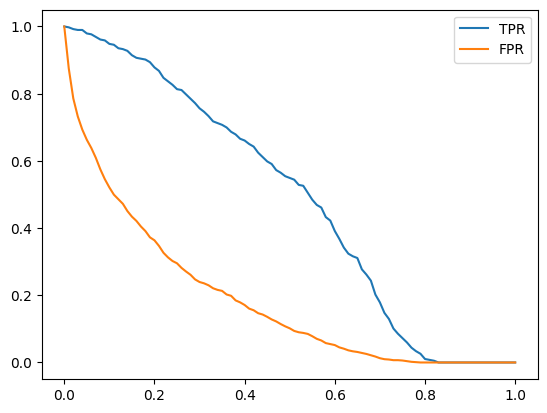

In [52]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

Both TPR and FPR start at 100% because at the threshold of 0.0, we predict "churn" for everyone:
- FPR is 100% because we have only false positives in the prediction. There are no true negatives: nobody is predicted as non-churning.
- TPR is 100% because we have only true positives and no false negatives.

As the threshold grows, both metrics decline but at different rates. Ideally, FPR should go down very quickly. A small FPR indicates that the model makes very few mistakes predicting negative examples (false positives). On the other hand, TPR should go down slowly, ideally staying near 100% all the time. A high TPR indicates that the model predicts true positives well. 

To better understand the meaning of TPR and FPR, let's compare it with two baseline models: a random model and an ideal model. 

### Random model

A random model outputs a random score between 0 and 1, regardless of the input. 

In [53]:
np.random.seed(1)
# Generates an array with random numbers between 0 and 1
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [54]:
# Pretends y_rand contains the predictions of our model
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

The accuracy for this model should be quite low. As we can see, it's 50%.

Let's calculate FPR and TPR for our random model. 

In [55]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [59]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


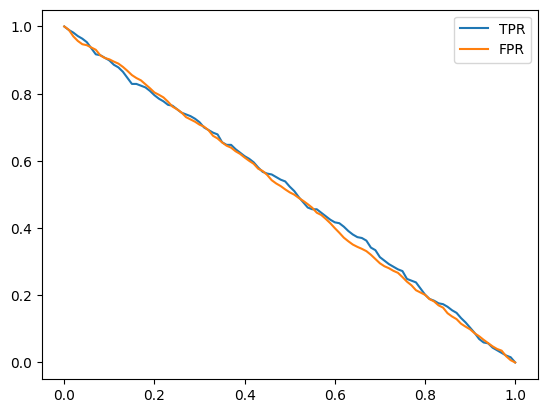

In [60]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

We can see that both TPR and FPR curves go from 100% to 0%, almost following the straight line. 

At the threshold of 0.0, we treat all customers as churning. Both TPR and FPR are 100%:
- FPR is 100% because we have only false positives: all non-churning customers are identified as churning.
- TPR is 100% because we have only true positives: we can correctly classify all churning customers as churning. 

### Ideal model

In [ ]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

In [ ]:

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [ ]:
1 - y_val.mean()

In [ ]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

In [ ]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

In [ ]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

In [ ]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

In [ ]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [ ]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC

In [ ]:
from sklearn.metrics import auc

In [ ]:
auc(fpr, tpr)

In [ ]:
auc(df_scores.fpr, df_scores.tpr)

In [ ]:
auc(df_ideal.fpr, df_ideal.tpr)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_val, y_pred)

In [ ]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [ ]:
import random

In [ ]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

In [ ]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

## 4.7 Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [ ]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [ ]:
dv, model = train(df_train, y_train, C=0.001)

In [ ]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [ ]:
y_pred = predict(df_val, dv, model)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
!pip install tqdm

In [ ]:
from tqdm.auto import tqdm

In [ ]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

In [ ]:
scores

In [ ]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

## 4.8 Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week